In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import re

from tqdm import tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas()
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
dumps = Path('/storage/monty/quest_challenge/stackexchange_parsed/').glob('*')
dumps = [path for path in dumps if path.joinpath('questions.tsv').exists()]

In [5]:
# dump = dumps[1]
# questions = pd.read_csv(dump / 'questions.tsv', sep='\t')
# answers = pd.read_csv(dump / 'answers.tsv', sep='\t')

In [6]:
all_questions, all_answers = [], []
offset = 0

for dump in tqdm_notebook(dumps):
    questions = pd.read_csv(dump / 'questions.tsv', sep='\t')
    answers = pd.read_csv(dump / 'answers.tsv', sep='\t')
    
    questions['host'] = answers['host'] = dump.name
       
    accepted_answers = questions['AcceptedAnswerId'].dropna().astype(int)
    answers['is_answer_accepted'] = answers['Id'].astype(int).isin(accepted_answers)
    
    questions['Id'] = questions['Id'].astype(int) + offset
    answers['Id'] = answers['Id'].astype(int) + offset
    answers['ParentId'] = answers['ParentId'].astype(int) + offset

    
    all_questions.append(questions)
    all_answers.append(answers)
    
    offset = max(questions['Id'].max(), answers['Id'].max()) + 1

In [7]:
len(all_answers)

176

In [8]:
all_questions = pd.concat(all_questions, sort=False).reset_index()
all_answers = pd.concat(all_answers, sort=False).reset_index()

In [9]:
all_questions.shape, all_answers.shape

((6476116, 17), (9806737, 13))

In [10]:
answers['is_answer_accepted'].mean()

0.2899348003259984

In [11]:
html_pattern = re.compile(r'<.*?>')

question_body = all_questions['Body'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))
question_title = all_questions['Title'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))

In [12]:
question_body_cleaned = question_body.progress_apply(lambda s: s.replace('\n','')).values

In [13]:
n_jobs = 32
chunksize = 100000
n_chunks = int(len(question_body_cleaned) / chunksize) + 1

In [14]:
# %%time
import fasttext
from multiprocessing import Pool

def predict_lang(sentences):
    model = fasttext.load_model('lid.176.bin')
    return model.predict(list(sentences), k=1)[0]

with Pool(n_jobs) as pool:
    question_lang = list(
        tqdm_notebook(
            pool.imap(predict_lang, [question_body_cleaned[i*chunksize : (i+1)*chunksize] for i in range(n_chunks)]),
            total = n_chunks
        )
    )
    
question_lang = list(map(np.array,question_lang))
question_lang = np.vstack(question_lang).flatten()

In [15]:
question_lang = np.array([l[-2:] for l in question_lang])

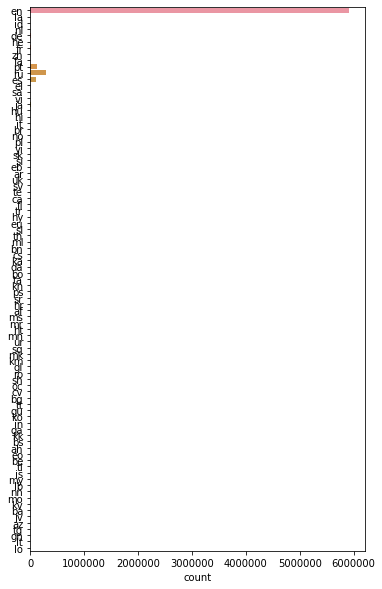

In [46]:
plt.figure(figsize=(6,10))
sns.countplot(y=question_lang, orient='h')

In [16]:
question_ans_agg_features = pd.concat([
    all_answers.groupby('ParentId')['Score'].max().rename('answers_max_score'),
    all_answers.groupby('ParentId')['Score'].mean().rename('answers_mean_score')
], axis=1, sort=False)

In [17]:
question_features = all_questions[['Id','host','username','Score','ViewCount','FavoriteCount','AnswerCount']]
question_features = question_features.merge(question_ans_agg_features, left_on='Id', right_on='ParentId', how='left')
question_features = pd.concat([question_features, question_title, question_body], axis=1, sort=False)

question_features = question_features.iloc[(question_lang=='en') & (all_questions['AnswerCount'].ravel() != 0)]

In [18]:
print(question_features.columns)

Index(['Id', 'host', 'username', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount', 'answers_max_score', 'answers_mean_score', 'Title',
       'Body'],
      dtype='object')


In [19]:
question_features.columns = ['id', 'host', 'question_username', 'question_score', 'question_views', 'question_favs',
       'answers_count', 'answers_max_score', 'answers_mean_score', 'title', 'body']

In [128]:
def select_answers(all_answers, max_answers_per_question =2):
    answer_ids = all_answers[['Id','ParentId','is_answer_accepted']]

    selected_answers = answer_ids['Id'][answer_ids['is_answer_accepted']].tolist()
    n_additional = max_answers_per_question - (answer_ids.groupby('ParentId')['is_answer_accepted'].sum() > 0).astype(int)

    additional_answers = answer_ids.merge(n_additional.rename('n_additional').reset_index(), on='ParentId')

    while len(additional_answers) > 0:
        print(len(additional_answers))
        additional_answers = additional_answers[~additional_answers['Id'].isin(selected_answers)]
        additional_answers = additional_answers[additional_answers['n_additional'] > 0]
        additional_answers = additional_answers.iloc[np.random.permutation(len(additional_answers))].reset_index(drop=True)
        selected_answers += additional_answers['Id'].loc[additional_answers['ParentId'].drop_duplicates().index].tolist()

        additional_answers['n_additional'] = additional_answers['n_additional'] - 1
    return selected_answers

In [130]:
selected_answers = all_answers['Id'].isin(select_answers(all_answers))

9806737
6811743
1806082


In [135]:
answer_features = all_answers[selected_answers][['ParentId', 'username', 'Body', 'Score','is_answer_accepted']]

In [143]:
answer_features['Body'] = answer_features['Body'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))

In [145]:
print(answer_features.columns)

Index(['ParentId', 'username', 'Body', 'Score', 'is_answer_accepted'], dtype='object')


In [146]:
answer_features.columns = ['ParentId', 'answer_username', 'answer', 'answer_score', 'is_answer_accepted']

In [148]:
qa_features = question_features.merge(answer_features, left_on='id', right_on='ParentId', how='inner')

In [151]:
qa_features.drop(columns=['ParentId'], inplace=True)

In [168]:
targets = [ 'question_score', 'question_views', 'question_favs', 
           'answers_count', 'answers_max_score',  'answers_mean_score', 'answer_score', 'is_answer_accepted']

qa_features[targets] = qa_features[targets].fillna(0)
qa_features[targets] = np.sign(qa_features[targets]) * np.log1p(np.abs(qa_features[targets]))
qa_features[targets] = qa_features[targets] / qa_features[targets].std()

In [172]:
# qa_features = qa_features[['id', 'host', 'question_username','answer_username', 'title','body', 'answer',
#                  'question_score', 'question_views','question_favs', 'answers_count', 'answers_max_score',
#                  'answers_mean_score', 'answer_score', 'is_answer_accepted']]

In [174]:
qa_features[['id', 'host', 'question_username', 'answer_username', 'title', 'body', 'answer']]\
    .to_csv('/storage/monty/quest_challenge/qa_stackexchange_cleaned.tsv', index=False)

In [176]:
qa_features[targets].to_hdf('/storage/monty/quest_challenge/qa_stackexchange_cleaned_targets.h5', 'targets')